# Citation Analysis: Journals Cited by a Research Organization

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to discover what academic journals are most frequenlty cited by authors affiliated to a selected research organization. These are the steps: 

1. We start from a specific organization GRID ID (and other parameters of choice)
2. Using the [publications API](https://docs.dimensions.ai/dsl/datasource-publications.html), we extract all publications authored by researchers at that institution. For each publication, we store all outgoing citations IDs using the `reference_ids` field
3. We query the API again to obtain other useful metadata for those outgoing citations e.g. title, publisher, journals etc..  
4. We analyse the data, in particular by segmenting it by journal and publisher 

In [22]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 24, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).


In [23]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *
import sys, json, time, os
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


## 1. Choosing a Research Organization

We can use the [organizations API](https://docs.dimensions.ai/dsl/datasource-organizations.html) to find the [GRID ID](https://grid.ac/institutes) for Berkeley University.

In [2]:
%%dsldf 

search organizations for "berkeley university" return organizations

Returned Organizations: 1 (total = 1)
Time: 0.55s


acronym city_name   country_name             id  latitude  \
0     UCB  Berkeley  United States  grid.47840.3f  37.87216   

                      linkout   longitude                                name  \
0  [http://www.berkeley.edu/] -122.258575  University of California, Berkeley   

   state_name        types  
0  California  [Education]

The ID we are looking for is [grid.47840.3f](https://www.grid.ac/institutes/grid.47840.3f).

### 1.1 Selecting a Field of Research ID

Similarly, we can use the API to identify relevant Field of Research (FoR) categories for Berkeley University. 

By using a specific FOR category we can make the subsequent data extraction & analysis a bit more focused. 

In [3]:
%%dsldf

search publications 
    where research_orgs.id = "grid.47840.3f"
    return category_for limit 10

Returned Category_for: 10
Time: 0.94s


count    id                                   name
0  41255  2206                 06 Biological Sciences
1  36976  2209                         09 Engineering
2  36521  2202                   02 Physical Sciences
3  32011  2211         11 Medical and Health Sciences
4  22550  2203                   03 Chemical Sciences
5  18529  2201               01 Mathematical Sciences
6  16377  2208  08 Information and Computing Sciences
7  15578  2581     0601 Biochemistry and Cell Biology
8  12848  2217   17 Psychology and Cognitive Sciences
9  12453  2620                          0604 Genetics

For example, let's focus on **08 Information and Computing Sciences**,  ID `2208` - 

Finally, we can also select a specific year range, e.g. the **last five years**. 

Let's save all of these variables so that we can reference them later on. 



In [4]:
GRIDID = "grid.47840.3f" #@param {type:"string"}

FOR_CODE = "2208"  #@param {type:"string"}

    
#@markdown The start/end year of publications used to extract patents
YEAR_START = 2015 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2021 #@param {type: "slider", min: 1950, max: 2021}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START


## 2. Getting the IDs of the outgoing citations  

In this section we use the Publications API to extract the Dimensions ID of all publications referenced by authors in the selected research organization. 

These identifiers can be found in the `reference_ids` field. 


In [5]:
publications = dsl.query_iterative(f"""

    search publications 
        where research_orgs.id = "{GRIDID}"
        and year in [{YEAR_START}:{YEAR_END}]
        and category_for.id="{FOR_CODE}"
        return publications[id+doi+unnest(reference_ids)]
        
""")

#
# preview the data
pubs_and_citations = publications.as_dataframe()
pubs_and_citations.head(5)

Starting iteration with limit=1000 skip=0 ...
0-1000 / 5000 (1.72s)
1000-2000 / 5000 (1.44s)
2000-3000 / 5000 (1.17s)
3000-4000 / 5000 (1.22s)
4000-5000 / 5000 (1.32s)
5000-5000 / 5000 (0.83s)
===
Records extracted: 122273


doi              id   reference_ids
0  10.1002/9780470015902.a0029363  pub.1144313713  pub.1125651848
1  10.1002/9780470015902.a0029363  pub.1144313713  pub.1137478539
2  10.1002/9780470015902.a0029363  pub.1144313713  pub.1125924300
3  10.1002/9780470015902.a0029363  pub.1144313713  pub.1069494746
4  10.1002/9780470015902.a0029363  pub.1144313713  pub.1125842877

### 2.1 Removing duplicates and counting most frequent citations

Since multiple authors/publications from our organization will be referencing the same target publications, we may have various duplicates in our `reference_ids` column. 

So want to remove those duplicates, while at the same time retaining that information by adding a new column `size` that counts how frequenlty a certain publication was cited. 

This can be easily achieved using [panda's group-by](https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe) function: 

In [6]:
# consider only IDs column
df = pubs_and_citations[['reference_ids']]
# group by ID and count
citations = df.groupby(df.columns.tolist(),as_index=False).size().sort_values("size", ascending=False)
# preview the data, most cited ID first
citations.head(10)

reference_ids  size
61052  pub.1093359587   185
68692  pub.1095689025   122
28639  pub.1038140272    93
7191   pub.1009767488    79
34149  pub.1045321436    69
39144  pub.1052031051    67
44323  pub.1061179979    65
65505  pub.1094727707    65
7393   pub.1010020120    61
61937  pub.1093626237    55

## 3. Enriching the citations IDs with other publication metadata 

In this step we use the outgoing citations IDs obtained above to query the [publications API](https://docs.dimensions.ai/dsl/datasource-publications.html) again. 

The goal is to retrieve more publications metadata so to be able to 'group' citations based on criteria of interest e.g. what journal they belong to. For example: 

* source_title
* publisher 
* year
* doi

NOTE Since we can have lots of publications to go through, the IDs list is *chunked* into smaller groups so to ensure the resulting API query is never too long ([more info here](https://api-lab.dimensions.ai/cookbooks/1-getting-started/6-Working-with-lists.html#5.-How-Long-can-lists-get?)). 

In [7]:

#
# get a list of citation IDs
pubids = list(citations['reference_ids'])


#
# DSL query - PS change the return statement to extract different metadata of interest 
query_template = """search publications 
                    where id in {}
                    return publications[id+doi+journal+year+publisher+type+issn]
                    limit 1000"""


#
# loop through all references-publications IDs in chunks and query Dimensions 
print(f"===\nExtracting publications data for {len(pubids)} citations...")
results = []
BATCHSIZE = 400
VERBOSE = False # set to True to see extraction logs

for chunk in tqdm(list(chunks_of(pubids, BATCHSIZE))):
    query = query_template.format(json.dumps(chunk))
    data = dsl.query(query, verbose=VERBOSE)
    results += data.publications
    time.sleep(0.5)

#
# save the citing pub data into a dataframe, remove duplicates and save
pubs_cited = pd.DataFrame().from_dict(results)
print("===\nCited Publications found: ", len(pubs_cited))


#
# transform the 'journal' column cause it contains nested data 
temp = pubs_cited['journal'].apply(pd.Series).rename(columns={"id": "journal.id", 
                                                              "title": "journal.title"}).drop([0], axis=1)
pubs_cited = pd.concat([pubs_cited.drop(['journal'], axis=1), temp], axis=1).sort_values('type')
pubs_cited.head(10)



===
Extracting publications data for 84942 citations...


  0%|          | 0/213 [00:00<?, ?it/s]

===
Cited Publications found:  84922


doi              id  \
42460                 10.1111/bju.14172  pub.1101126388   
56658                10.1101/gr.4252305  pub.1005193627   
56659                10.3758/bf03196772  pub.1005243527   
56660         10.1007/s11142-005-1532-6  pub.1005399122   
56661                10.1175/jcli3431.1  pub.1005441257   
56662  10.1111/j.1468-0262.2005.00619.x  pub.1005782649   
56663         10.1016/j.fss.2004.10.011  pub.1005489135   
56664  10.1097/00001163-200504000-00002  pub.1005247850   
56665        10.1103/physrevb.71.125207  pub.1005474492   
56667           10.1145/1047124.1047509  pub.1026275367   

                                       publisher     type    year  \
42460                                      Wiley  article  2018.0   
56658              Cold Spring Harbor Laboratory  article  2005.0   
56659                            Springer Nature  article  2005.0   
56660                            Springer Nature  article  2005.0   
56661            American Meteorological Society  article  2005.0   
56662                    The Econometric Society  article  2005.0   
56663                                   Elsevier  article  2005.0   
56664                             Wolters Kluwer  article  2005.0   
56665            American Physical Society (APS)  article  2005.0   
56667  Association for Computing Machinery (ACM)  article  2005.0   

                                               issn    journal.id  \
42460                        [1464-4096, 1464-410X]  jour.1103922   
56658                        [1088-9051, 1549-5469]  jour.1101964   
56659                        [1069-9384, 1531-5320]  jour.1082645   
56660                        [1380-6653, 1573-7136]  jour.1136096   
56661                        [0894-8755, 1520-0442]  jour.1312082   
56662                        [0012-9682, 1468-0262]  jour.1027609   
56663                        [0165-0114, 1872-6801]  jour.1052629   
56664                        [0896-3746, 1550-5081]  jour.1099767   
56665  [2469-9950, 1095-3795, 1098-0121, 1550-235x]  jour.1320488   
56667                        [0097-8418, 2331-3927]  jour.1137050   

                       journal.title  
42460              BJU International  
56658                Genome Research  
56659  Psychonomic Bulletin & Review  
56660   Review of Accounting Studies  
56661             Journal of Climate  
56662                   Econometrica  
56663         Fuzzy Sets and Systems  
56664       Infants & Young Children  
56665              Physical Review B  
56667            ACM SIGCSE Bulletin

### 3.1 Adding the citations counts 

We achieve this by joining this data with the ones we extracted before, that is, `citations`

> Note: if there are a lot of publications, this step can take some time. 

In [8]:
pubs_cited = pubs_cited.merge(citations, left_on='id', right_on='reference_ids')

pubs_cited.head(10)

doi              id  \
0                 10.1111/bju.14172  pub.1101126388   
1                10.1101/gr.4252305  pub.1005193627   
2                10.3758/bf03196772  pub.1005243527   
3         10.1007/s11142-005-1532-6  pub.1005399122   
4                10.1175/jcli3431.1  pub.1005441257   
5  10.1111/j.1468-0262.2005.00619.x  pub.1005782649   
6         10.1016/j.fss.2004.10.011  pub.1005489135   
7  10.1097/00001163-200504000-00002  pub.1005247850   
8        10.1103/physrevb.71.125207  pub.1005474492   
9           10.1145/1047124.1047509  pub.1026275367   

                                   publisher     type    year  \
0                                      Wiley  article  2018.0   
1              Cold Spring Harbor Laboratory  article  2005.0   
2                            Springer Nature  article  2005.0   
3                            Springer Nature  article  2005.0   
4            American Meteorological Society  article  2005.0   
5                    The Econometric Society  article  2005.0   
6                                   Elsevier  article  2005.0   
7                             Wolters Kluwer  article  2005.0   
8            American Physical Society (APS)  article  2005.0   
9  Association for Computing Machinery (ACM)  article  2005.0   

                                           issn    journal.id  \
0                        [1464-4096, 1464-410X]  jour.1103922   
1                        [1088-9051, 1549-5469]  jour.1101964   
2                        [1069-9384, 1531-5320]  jour.1082645   
3                        [1380-6653, 1573-7136]  jour.1136096   
4                        [0894-8755, 1520-0442]  jour.1312082   
5                        [0012-9682, 1468-0262]  jour.1027609   
6                        [0165-0114, 1872-6801]  jour.1052629   
7                        [0896-3746, 1550-5081]  jour.1099767   
8  [2469-9950, 1095-3795, 1098-0121, 1550-235x]  jour.1320488   
9                        [0097-8418, 2331-3927]  jour.1137050   

                   journal.title   reference_ids  size  
0              BJU International  pub.1101126388     1  
1                Genome Research  pub.1005193627     1  
2  Psychonomic Bulletin & Review  pub.1005243527     1  
3   Review of Accounting Studies  pub.1005399122     1  
4             Journal of Climate  pub.1005441257     1  
5                   Econometrica  pub.1005782649     1  
6         Fuzzy Sets and Systems  pub.1005489135     1  
7       Infants & Young Children  pub.1005247850     1  
8              Physical Review B  pub.1005474492     1  
9            ACM SIGCSE Bulletin  pub.1026275367     1

## 4. Journal Analysis

Finally, we can analyze the citing publications by grouping them by source journal. This can be achieved easily thanks to pandas' Dataframe methods.  

### 4.1 Number of Unique journals

In [9]:
pubs_cited['journal.id'].describe()

count            58582
unique            6493
top       jour.1017736
freq               771
Name: journal.id, dtype: object

### 4.2 Most frequent journals

In [10]:
journals = pubs_cited.value_counts(['journal.title', 'publisher'])
journals = journals.to_frame().reset_index().rename(columns= {0: 'citations', 'journal.title' : 'title'})
journals.index.name = 'index'

#preview
journals.head(100)

title  \
index                                                      
0                        The Journal of Chemical Physics   
1                           ACM Transactions on Graphics   
2                IEEE Transactions on Information Theory   
3                                                 Nature   
4      Proceedings of the National Academy of Science...   
...                                                  ...   
95                      Expert Systems with Applications   
96                                Transportation Science   
97                       New England Journal of Medicine   
98             IEEE Transactions on Vehicular Technology   
99                      IEEE Transactions on Cybernetics   

                                               publisher  citations  
index                                                                
0                                         AIP Publishing        771  
1              Association for Computing Machinery (ACM)        642  
2      Institute of Electrical and Electronics Engine...        632  
3                                        Springer Nature        583  
4        Proceedings of the National Academy of Sciences        582  
...                                                  ...        ...  
95                                              Elsevier         94  
96     Institute for Operations Research and the Mana...         91  
97                         Massachusetts Medical Society         91  
98     Institute of Electrical and Electronics Engine...         91  
99     Institute of Electrical and Electronics Engine...         91  

[100 rows x 3 columns]

### 4.3 Top 50 journals chart, by publisher

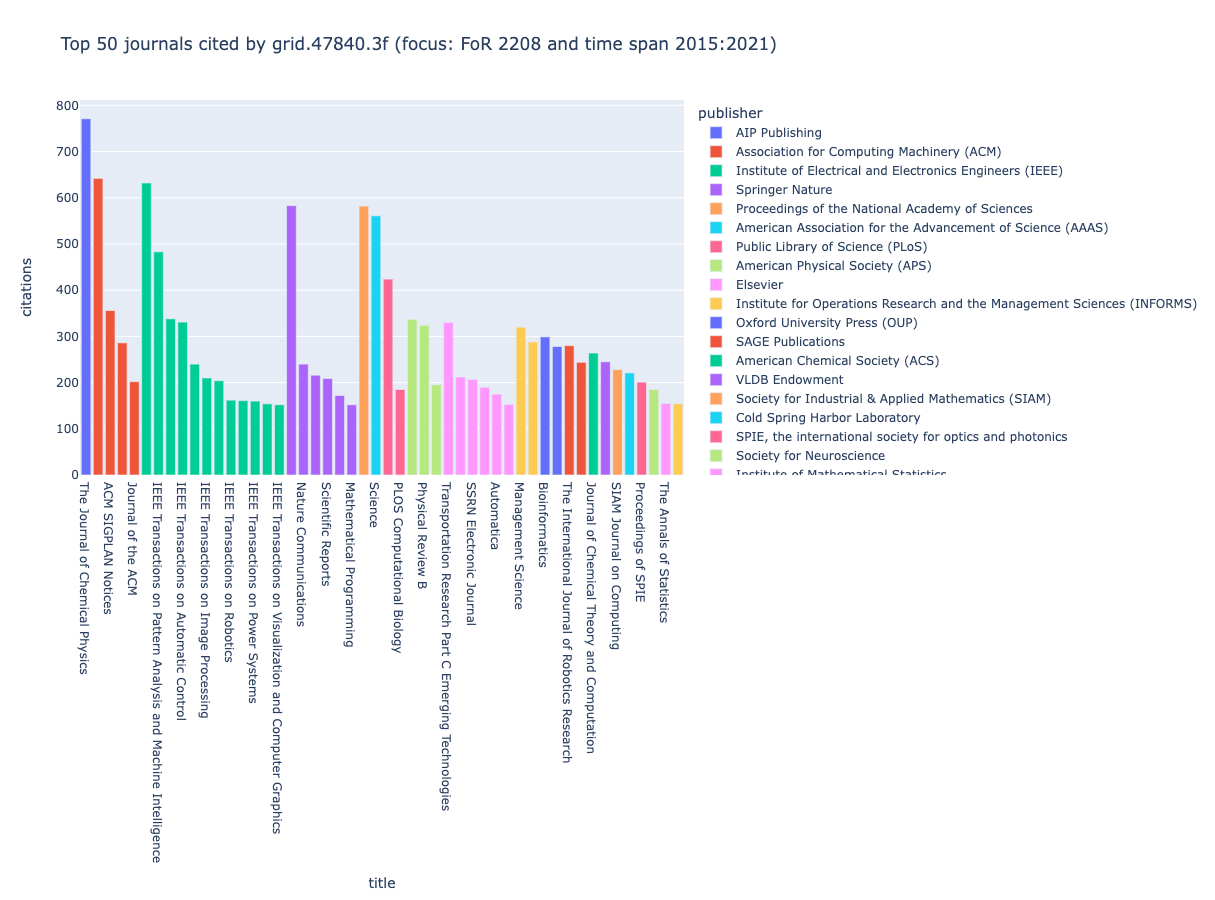

In [11]:
px.bar(journals[:50], 
       x="title", y="citations", color="publisher",
       height=900,
       title=f"Top 50 journals cited by {GRIDID} (focus: FoR {FOR_CODE} and time span {YEAR_START}:{YEAR_END})")

### 4.4 Top 20 journals by year of the cited publication

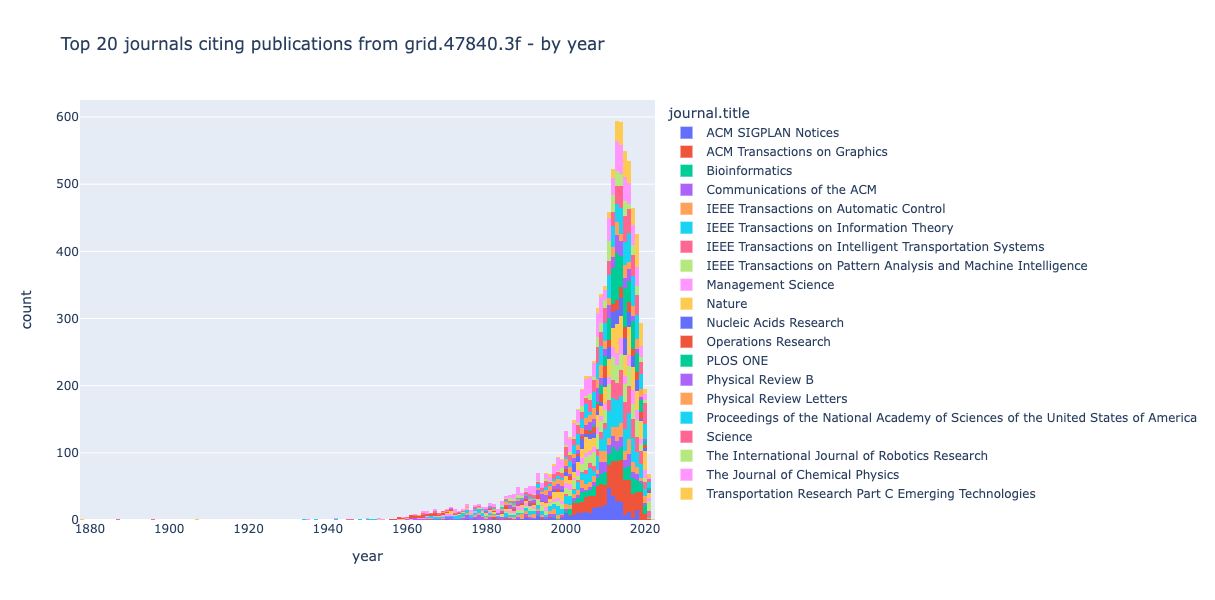

In [12]:

THRESHOLD = 20  #@param {type: "slider", min: 10, max: 100}

# suppress empty values
pubs_cited.fillna("-no value-", inplace=True)

# make publications list smaller by only showing top journals
pubs_citing_topjournals = pubs_cited[pubs_cited['journal.title'].isin(list(journals[:THRESHOLD]['title']))].sort_values('journal.title')

# build histogram
px.histogram(pubs_citing_topjournals, 
             x="year", 
             color="journal.title", 
             height=600,
             title=f"Top {THRESHOLD} journals citing publications from {GRIDID} - by year")

---
## Conclusions

In this notebook we have shown how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to discover what academic journals are most frequenlty cited by authors affiliated to a selected research organization. 

This only scratches the surface of the possible applications of publication data, but hopefully it'll give you a few basic tools to get started building your own applications. For more background, see the [list of fields](https://docs.dimensions.ai/dsl/datasource-publications.html) available via the Publications API. 
